# Classifying ALL with Stacking Classifier

This notebook covers Stacking Classifier, with XGBoost as a meta classifier and the following base estimators:

- K-nearest neighbors
- SVM
- Random Forest
- Logistic Regression
- Gaussian Naive Bayes
- Multi-layer Perceptron
- Extra Trees

The performed steps:

1. Each base estimator was optimized with Optuna to find the best hyperparameters 
2. Two worst performers, K-nearest neighbors and Gaussian Naïve Bayes, were dropped
3. Stacking classifier was ran using remaining tuned estimators and XGBoost with default parameters. The performance was recorded.
4. Optuna was used to optimize the stacking classifier. Optuna's parameter space included the final estimator (XGBoost) parameters.

We used macro averaged f1_score as the metrics to find the best Optuna's trial.

## Mount Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install optuna

## Dependencies

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import joblib

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

## from sklearn.utils.fixes import loguniform
from scipy.stats import uniform, truncnorm, randint, loguniform

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Function for creating model pipelines - imblearn
## from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
## from imblearn.over_sampling import SMOTE

# Import XGBoost
from xgboost import XGBClassifier

# Import Optuna
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback


import warnings
warnings.filterwarnings('ignore')

random_state = 10

In [5]:
# Import the script from different folder
import sys  
#  sys.path.append('/content/drive/MyDrive/Omdena/Team1/scripts')
sys.path.append('../scripts')

import metrics_utilities as mu

## Batch_4 Train Dataset

In [6]:
# df_train = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/train_data.pickle')
df_train = pd.read_pickle('../data/batch_4/train_data.pickle')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.185833,0.0,0.00000,0.000000,0.0,0.0,0.0,0.231458,0.0,0.0,...,0.545079,0.170755,0.0,0.096298,0.174819,0.0,0.0,0.361853,0.0,0
1,0.123157,0.0,0.56544,0.350086,0.0,0.0,0.0,0.228849,0.0,0.0,...,0.663390,0.115025,0.0,0.099379,0.516193,0.0,0.0,0.239392,0.0,1
2,0.197977,0.0,0.00000,0.000000,0.0,0.0,0.0,0.155163,0.0,0.0,...,0.663023,0.021846,0.0,0.000000,0.173690,0.0,0.0,0.270634,0.0,1
3,0.580151,0.0,0.00000,0.000000,0.0,0.0,0.0,0.298566,0.0,0.0,...,0.470815,0.000000,0.0,0.000000,0.118325,0.0,0.0,0.000000,0.0,0
4,0.066450,0.0,0.00000,0.000000,0.0,0.0,0.0,0.145156,0.0,0.0,...,0.645798,0.015262,0.0,0.027536,0.275665,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [7]:
X_train = df_train.iloc[:, : -1]
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(11917, 4608) (11917,)


## Batch_4 Test Dataset

In [8]:
# df_test = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_4/test_data.pickle')
df_test = pd.read_pickle('../data/batch_4/test_data.pickle')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.141500,0.0,0.000000,0.000000,0.0,0.0,0.0,0.151137,0.0,0.0,...,0.885778,0.066009,0.0,0.169458,0.570154,0.0,0.0,0.090579,0.0,0
1,0.047403,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.649062,0.260996,0.0,0.049776,0.494771,0.0,0.0,0.480568,0.0,0
2,0.000000,0.0,0.000000,0.023559,0.0,0.0,0.0,0.060329,0.0,0.0,...,0.725523,0.166289,0.0,0.131945,0.299330,0.0,0.0,0.000000,0.0,0
3,0.002286,0.0,0.655825,0.259398,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.626934,0.244303,0.0,0.100791,0.448022,0.0,0.0,0.295682,0.0,0
4,0.279953,0.0,0.000000,0.000000,0.0,0.0,0.0,0.168589,0.0,0.0,...,0.489483,0.166786,0.0,0.000000,0.212874,0.0,0.0,0.000000,0.0,0


#### Separate features and labels

In [9]:
X_test = df_test.iloc[:, :-1]
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(1794, 4608) (1794,)


#### Names of Classes

In [10]:
target_names = ['hem', 'all']

# Tune base estimators

## =================================================

# SVM - Optuna

## Optuna Objective Function

In [161]:
def objective(trial):
    """Define the objective function"""

    params = {
        'C' : trial.suggest_loguniform('C', 1e-1, 1e2),
        #'kernel' : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf']),
        'gamma' : trial.suggest_loguniform('gamma', 1e-1, 1e2)
    }

    # Fit the model
    model = SVC(**params, kernel='linear', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [162]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 00:09:02,378] A new study created in memory with name: no-name-2841730f-05d2-4009-bc52-e3dfb89ae0f3


## Optimize the Objective Function

In [163]:
study.optimize(objective, n_jobs=-1, n_trials=40)

[I 2023-04-28 00:18:29,868] Trial 3 finished with value: 0.7413311264055266 and parameters: {'C': 1.029945338103518, 'gamma': 0.5901355669046173}. Best is trial 3 with value: 0.7413311264055266.
[I 2023-04-28 00:19:56,723] Trial 2 finished with value: 0.7275484910686105 and parameters: {'C': 2.3975366852055635, 'gamma': 2.9431060828956985}. Best is trial 3 with value: 0.7413311264055266.
[I 2023-04-28 00:22:18,474] Trial 1 finished with value: 0.7154762136268465 and parameters: {'C': 6.269065942519452, 'gamma': 89.33970128754454}. Best is trial 3 with value: 0.7413311264055266.
[I 2023-04-28 00:23:21,397] Trial 0 finished with value: 0.706485594705581 and parameters: {'C': 8.84205415901047, 'gamma': 0.9168340002717398}. Best is trial 3 with value: 0.7413311264055266.
[I 2023-04-28 00:29:03,798] Trial 5 finished with value: 0.7379274088236691 and parameters: {'C': 1.6541105972919632, 'gamma': 1.6916680117273615}. Best is trial 3 with value: 0.7413311264055266.
[I 2023-04-28 00:30:44,252

#### Let's do 40 more trials

In [164]:
study.optimize(objective, n_jobs=-1, n_trials=40)

[I 2023-04-28 01:48:46,100] Trial 42 finished with value: 0.7500263613768171 and parameters: {'C': 0.24829748877261368, 'gamma': 3.5156238910126087}. Best is trial 24 with value: 0.7600950084363436.
[I 2023-04-28 01:50:36,022] Trial 41 finished with value: 0.7382512849248022 and parameters: {'C': 1.1284987172957655, 'gamma': 1.2693040032454772}. Best is trial 24 with value: 0.7600950084363436.
[I 2023-04-28 01:50:43,775] Trial 40 finished with value: 0.7365432985986345 and parameters: {'C': 1.237044336509514, 'gamma': 3.5885698016535392}. Best is trial 24 with value: 0.7600950084363436.
[I 2023-04-28 01:51:03,502] Trial 43 finished with value: 0.7363342623727491 and parameters: {'C': 1.4292959288979006, 'gamma': 2.996448043607603}. Best is trial 24 with value: 0.7600950084363436.
[I 2023-04-28 01:55:33,852] Trial 44 finished with value: 0.7564056614229557 and parameters: {'C': 0.15328937229425502, 'gamma': 2.813641984417937}. Best is trial 24 with value: 0.7600950084363436.
[I 2023-04-

#### Let's finish with 20 trials (total 100 trials)

In [165]:
study.optimize(objective, n_jobs=-1, n_trials=20)

[I 2023-04-28 03:01:05,640] Trial 80 finished with value: 0.752917271188775 and parameters: {'C': 0.23352357435616564, 'gamma': 41.56591184719434}. Best is trial 72 with value: 0.7612079076514707.
[I 2023-04-28 03:01:11,619] Trial 82 finished with value: 0.7518256308323517 and parameters: {'C': 0.23692007589318825, 'gamma': 50.42087708046739}. Best is trial 72 with value: 0.7612079076514707.
[I 2023-04-28 03:01:29,682] Trial 81 finished with value: 0.7512249237311639 and parameters: {'C': 0.237657412687639, 'gamma': 44.975485029171594}. Best is trial 72 with value: 0.7612079076514707.
[I 2023-04-28 03:01:41,764] Trial 83 finished with value: 0.7498114034020393 and parameters: {'C': 0.33698430372680926, 'gamma': 39.40260559193388}. Best is trial 72 with value: 0.7612079076514707.
[I 2023-04-28 03:07:36,068] Trial 85 finished with value: 0.7599725095436931 and parameters: {'C': 0.1293988216490246, 'gamma': 79.87691947240573}. Best is trial 72 with value: 0.7612079076514707.
[I 2023-04-28

## Best Parameters

In [166]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7613331095100544
  Params: 
    C: 0.12103996361181649
    gamma: 24.34232406568725


## Re-fit the model

In [167]:
params_svm = trial.params
params_svm

{'C': 0.12103996361181649, 'gamma': 24.34232406568725}

In [168]:
svm = SVC(**params_svm, kernel='linear', random_state=random_state)
svm.fit(X_train, y_train)

SVC(C=0.12103996361181649, gamma=24.34232406568725, kernel='linear',
    random_state=10)

In [169]:
# Save the model
joblib.dump(svm, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/svm_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/svm_f1ma_1.pkl']

In [170]:
y_pred_svm = svm.predict(X_test)

In [171]:
accuracy = accuracy_score(y_test, y_pred_svm)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 84.67


In [172]:
# Compare training and testing scores
print(f"Training Data Score: {svm.score(X_train, y_train)}")
print(f"Testing Data Score: {svm.score(X_test, y_test)}")

Training Data Score: 0.9086179407569019
Testing Data Score: 0.846711259754738


In [173]:
cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

[[ 223  116]
 [ 159 1296]]


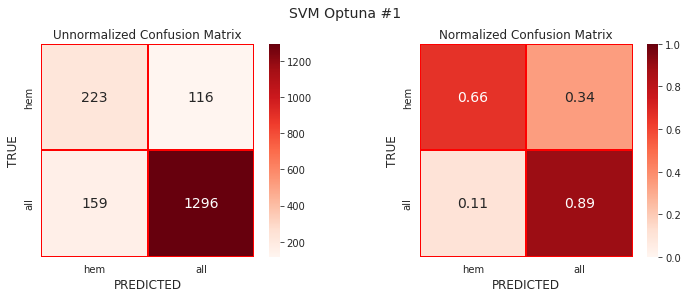

In [174]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('SVM Optuna #1', y_test, y_pred_svm, target_names, 'Reds')

In [175]:
print(classification_report(y_test, y_pred_svm, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.58      0.66      0.62       339
         all       0.92      0.89      0.90      1455

    accuracy                           0.85      1794
   macro avg       0.75      0.77      0.76      1794
weighted avg       0.85      0.85      0.85      1794



## =================================================

# KNN - Optuna

## Optuna Objective Function

In [77]:
def objective(trial):
    """Define the objective function"""

    params = {
        'n_neighbors' : trial.suggest_int('n_neighbors', 1, 16),
        'metric' : trial.suggest_categorical('metric', ['minkowski','euclidean','manhattan']),
        'weights' : trial.suggest_categorical('weights', ['uniform','distance'])
    }

    # Fit the model
    model = KNeighborsClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [80]:
study = optuna.create_study(direction='maximize')

[I 2023-04-27 18:01:55,934] A new study created in memory with name: no-name-fbd37627-87c0-43f8-8f35-c66a5c449b07


## Optimize the Objective Function

In [81]:
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2023-04-27 18:02:18,172] Trial 3 finished with value: 0.681771879785874 and parameters: {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 3 with value: 0.681771879785874.
[I 2023-04-27 18:02:18,233] Trial 1 finished with value: 0.6525931916818685 and parameters: {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 3 with value: 0.681771879785874.
[I 2023-04-27 18:02:18,345] Trial 2 finished with value: 0.6451137053274926 and parameters: {'n_neighbors': 13, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 3 with value: 0.681771879785874.
[I 2023-04-27 18:02:18,445] Trial 0 finished with value: 0.6587379577323844 and parameters: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 3 with value: 0.681771879785874.
[I 2023-04-27 18:02:32,867] Trial 5 finished with value: 0.6852223400440942 and parameters: {'n_neighbors': 15, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 5 with va

## Best Parameters

In [82]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.6917231503579953
  Params: 
    n_neighbors: 6
    metric: euclidean
    weights: distance


## Re-fit the model

In [83]:
params_knn = trial.params
params_knn

{'n_neighbors': 6, 'metric': 'euclidean', 'weights': 'distance'}

In [84]:
knn = KNeighborsClassifier(**params_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=6, weights='distance')

In [85]:
# Save the model
joblib.dump(knn, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/knn_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/knn_f1ma_1.pkl']

In [86]:
y_pred_knn = knn.predict(X_test)

In [87]:
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 77.93


In [88]:
# Compare training and testing scores
print(f"Training Data Score: {knn.score(X_train, y_train)}")
print(f"Testing Data Score: {knn.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.7792642140468228


In [89]:
cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

[[ 221  118]
 [ 278 1177]]


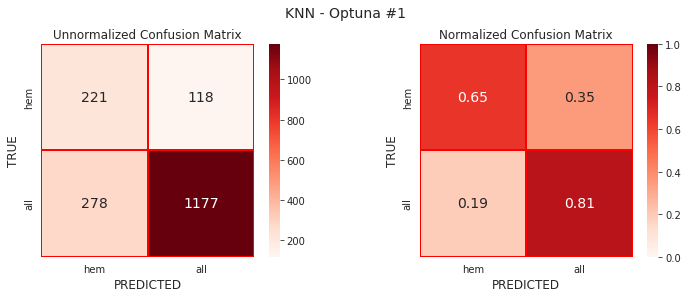

In [90]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('KNN - Optuna #1', y_test, y_pred_knn, target_names, 'Reds')

In [91]:
print(classification_report(y_test, y_pred_knn, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.44      0.65      0.53       339
         all       0.91      0.81      0.86      1455

    accuracy                           0.78      1794
   macro avg       0.68      0.73      0.69      1794
weighted avg       0.82      0.78      0.79      1794



## =================================================

# Logistic Regression - Optuna

## Optuna Objective Function

In [10]:
def objective(trial):
    """Define the objective function"""

    params = {
        'penalty' : trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
        ### 'l1_ratio': trial.suggest_float('l1_ratio', 0, 1, log=False),
        'C' : trial.suggest_float('C', 1e-1, 1e3, log=True),
        'tol' : trial.suggest_float('tol', 1e-4, 1e-2, log=True),
        'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
        ### 'solver' : trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 0, 1, log=False)
        params['solver'] = 'saga'
    else:
        params['solver'] = trial.suggest_categorical('solver', ['liblinear', 'saga'])


    # Fit the model
    model = LogisticRegression(**params, random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [11]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 22:29:32,094] A new study created in memory with name: no-name-f867eb32-f3be-4365-94b0-12ca43553ee5


## Optimize the Objective Function

In [12]:
study.optimize(objective, n_jobs=-1, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-04-28 22:29:51,278] Trial 0 finished with value: 0.7404811078174012 and parameters: {'penalty': 'l2', 'C': 0.16025381470841848, 'tol': 0.0008789648705926612, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7404811078174012.
[I 2023-04-28 22:32:38,775] Trial 1 finished with value: 0.7316356942496494 and parameters: {'penalty': 'elasticnet', 'C': 0.1268863392241254, 'tol': 0.00029449016008604285, 'fit_intercept': True, 'l1_ratio': 0.5628768420900726}. Best is trial 0 with value: 0.7404811078174012.
[I 2023-04-28 22:33:18,611] Trial 3 finished with value: 0.7381313224946928 and parameters: {'penalty': 'elasticnet', 'C': 27.386763941720496, 'tol': 0.0005336358098442851, 'fit_intercept': True, 'l1_ratio': 0.3271451012597074}. Best is trial 0 with value: 0.7404811078174012.
[I 2023-04-28 22:33:24,030] Trial 2 finished with value: 0.7364472795525364 and parameters: {'penalty': 'l1', 'C': 9.14772194704816, 'tol': 0.0002465251914163499, 'fit_intercept': True

## Best Parameters

In [13]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7505172656800564
  Params: 
    penalty: l2
    C: 0.41725619274351355
    tol: 0.0034947786528423015
    fit_intercept: True
    solver: liblinear


## Re-fit the model

In [14]:
params_lr = trial.params
params_lr

{'penalty': 'l2',
 'C': 0.41725619274351355,
 'tol': 0.0034947786528423015,
 'fit_intercept': True,
 'solver': 'liblinear'}

In [15]:
lr = LogisticRegression(**params_lr, random_state=random_state)
lr.fit(X_train, y_train)

LogisticRegression(C=0.41725619274351355, random_state=10, solver='liblinear',
                   tol=0.0034947786528423015)

In [16]:
# Save the model
joblib.dump(lr, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/lr_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/lr_f1ma_1.pkl']

In [17]:
y_pred_lr = lr.predict(X_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred_lr)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.50


In [19]:
# Compare training and testing scores
print(f"Training Data Score: {lr.score(X_train, y_train)}")
print(f"Testing Data Score: {lr.score(X_test, y_test)}")

Training Data Score: 0.9106318704371905
Testing Data Score: 0.835005574136009


In [20]:
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

[[ 227  112]
 [ 184 1271]]


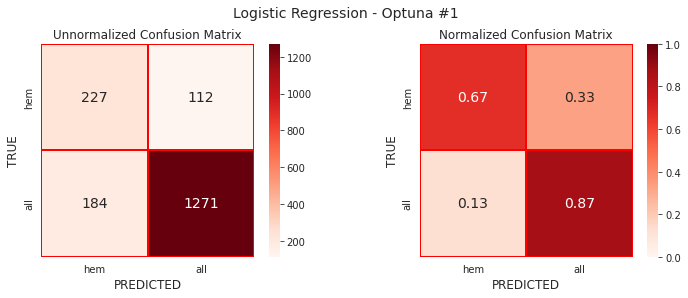

In [21]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Logistic Regression - Optuna #1', y_test, y_pred_lr, target_names, 'Reds')

In [22]:
print(classification_report(y_test, y_pred_lr, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.55      0.67      0.61       339
         all       0.92      0.87      0.90      1455

    accuracy                           0.84      1794
   macro avg       0.74      0.77      0.75      1794
weighted avg       0.85      0.84      0.84      1794



## =================================================

# Random Forest - Optuna

## Optuna Objective Function

In [13]:
def objective(trial):
    """Define the objective function"""

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 700, 10),
        # 'max_depth' : trial.suggest_int('max_depth', 1, 32),
        # 'max_features' : trial.suggest_int('max_features', 2, 20),
        'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        # 'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    # Fit the model
    model = RandomForestClassifier(**params, random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [14]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 12:56:23,771] A new study created in memory with name: no-name-8c81861d-6f85-4821-88fb-83c3a9ecb3ec


## Optimize the Objective Function

In [15]:
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2023-04-28 12:57:00,478] Trial 2 finished with value: 0.7240792387827086 and parameters: {'n_estimators': 180, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 2 with value: 0.7240792387827086.
[I 2023-04-28 12:57:24,675] Trial 3 finished with value: 0.7290529240782806 and parameters: {'n_estimators': 470, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 3 with value: 0.7290529240782806.
[I 2023-04-28 12:57:58,272] Trial 4 finished with value: 0.730781172379533 and parameters: {'n_estimators': 590, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'entropy'}. Best is trial 4 with value: 0.730781172379533.
[I 2023-04-28 12:57:59,693] Trial 5 finished with value: 0.7386915576970086 and parameters: {'n_estimators': 310, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 5 with v

#### Check 10 more trials

In [16]:
study.optimize(objective, n_jobs=-1, n_trials=10)

[I 2023-04-28 14:35:53,545] Trial 103 finished with value: 0.7497776281390707 and parameters: {'n_estimators': 160, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 34 with value: 0.7682699158178145.
[I 2023-04-28 14:36:02,403] Trial 100 finished with value: 0.7557586644125105 and parameters: {'n_estimators': 190, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 34 with value: 0.7682699158178145.
[I 2023-04-28 14:36:03,202] Trial 101 finished with value: 0.7557586644125105 and parameters: {'n_estimators': 190, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 34 with value: 0.7682699158178145.
[I 2023-04-28 14:39:20,153] Trial 102 finished with value: 0.7582179501849944 and parameters: {'n_estimators': 640, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best 

## Best Parameters

In [17]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 110
Best trial:
  Value: 0.7682699158178145
  Params: 
    n_estimators: 630
    max_features: sqrt
    min_samples_split: 5
    min_samples_leaf: 1
    criterion: entropy


## Re-fit the model

In [18]:
params_rf = trial.params
params_rf

{'n_estimators': 630,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'criterion': 'entropy'}

In [19]:
rf = RandomForestClassifier(**params_rf, random_state=random_state)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=630, random_state=10)

In [26]:
# Save the model
joblib.dump(rf, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/rf_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/rf_f1ma_1.pkl']

In [20]:
y_pred_rf = rf.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.73


In [22]:
# Compare training and testing scores
print(f"Training Data Score: {rf.score(X_train, y_train)}")
print(f"Testing Data Score: {rf.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8573021181716833


In [23]:
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

[[ 213  126]
 [ 130 1325]]


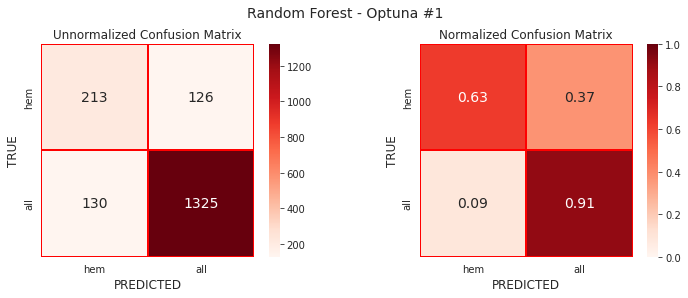

In [24]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Random Forest - Optuna #1', y_test, y_pred_rf, target_names, 'Reds')

In [25]:
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.62      0.63      0.62       339
         all       0.91      0.91      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.77      0.77      1794
weighted avg       0.86      0.86      0.86      1794



## =================================================

# Multi-layer Perceptron - Optuna

## Optuna Objective Function

In [12]:
def objective(trial):
    """Define the objective function"""

    params = {
        'momentum' : trial.suggest_float('momentum', 0.0, 1.0),
        'learning_rate_init' : trial.suggest_float('learning_rate_init', 1e-5, 1e-3, log=True),
        'power_t' : trial.suggest_float('power_t', 0.2, 0.8, step=0.1)
    }

    # Fit the model
    ### model = MLPClassifier(**params, hidden_layer_sizes=(10, 10, 10), random_state=random_state)
    model = MLPClassifier(**params, hidden_layer_sizes=(100, 50), random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [13]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 15:59:04,141] A new study created in memory with name: no-name-8b64ad09-e96f-4ee5-a1ac-6c4fab6d0d96


## Optimize the Objective Function

## Outputs for hidden_layer_sizes=(100, 50)

#### Run first 20 trials

In [14]:
study.optimize(objective, n_jobs=-1, n_trials=20)

[I 2023-04-28 16:07:50,530] Trial 0 finished with value: 0.7615702057037411 and parameters: {'momentum': 0.9693005937215683, 'learning_rate_init': 5.636869547178541e-05, 'power_t': 0.30000000000000004}. Best is trial 0 with value: 0.7615702057037411.
[I 2023-04-28 16:07:55,966] Trial 1 finished with value: 0.7368131225615785 and parameters: {'momentum': 0.8085272927971136, 'learning_rate_init': 0.00010339111125918508, 'power_t': 0.7}. Best is trial 0 with value: 0.7615702057037411.
[I 2023-04-28 16:16:08,960] Trial 2 finished with value: 0.7577237781681128 and parameters: {'momentum': 0.4080735679312585, 'learning_rate_init': 9.324754885394715e-05, 'power_t': 0.8}. Best is trial 0 with value: 0.7615702057037411.
[I 2023-04-28 16:20:19,864] Trial 3 finished with value: 0.7747847919655667 and parameters: {'momentum': 0.7751258730451894, 'learning_rate_init': 0.0004584475492777238, 'power_t': 0.2}. Best is trial 3 with value: 0.7747847919655667.
[I 2023-04-28 16:23:35,314] Trial 4 finishe

#### Add 30 more trials (total 50)

In [ ]:
study.optimize(objective, n_jobs=-1, n_trials=30)

[I 2023-04-28 17:35:53,783] Trial 21 finished with value: 0.7357054761515585 and parameters: {'momentum': 0.32118782418275366, 'learning_rate_init': 0.0008942721015783006, 'power_t': 0.30000000000000004}. Best is trial 19 with value: 0.7787548082099267.
[I 2023-04-28 17:40:34,679] Trial 20 finished with value: 0.7676999325493417 and parameters: {'momentum': 0.28402180433066493, 'learning_rate_init': 0.0009705640980759128, 'power_t': 0.30000000000000004}. Best is trial 19 with value: 0.7787548082099267.
[I 2023-04-28 17:45:27,626] Trial 22 finished with value: 0.7647128574123481 and parameters: {'momentum': 0.5035745651076637, 'learning_rate_init': 0.000542239583228065, 'power_t': 0.6000000000000001}. Best is trial 19 with value: 0.7787548082099267.
[I 2023-04-28 17:47:32,690] Trial 23 finished with value: 0.7634391121515585 and parameters: {'momentum': 0.5233445894061597, 'learning_rate_init': 0.0006153548666244057, 'power_t': 0.6000000000000001}. Best is trial 19 with value: 0.7787548

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 50
Best trial:
  Value: 0.7823512855104675
  Params: 
    momentum: 0.7467805285225793
    learning_rate_init: 0.0004616656166415659
    power_t: 0.2


## Re-fit the model

In [ ]:
params_mlp = trial.params
params_mlp

{'momentum': 0.7467805285225793,
 'learning_rate_init': 0.0004616656166415659,
 'power_t': 0.2}

In [ ]:
### mlp = MLPClassifier(**params_mlp, hidden_layer_sizes=(10, 10, 10), random_state=random_state)
mlp = MLPClassifier(**params_mlp, hidden_layer_sizes=(100, 50), random_state=random_state)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50),
              learning_rate_init=0.0004616656166415659,
              momentum=0.7467805285225793, power_t=0.2, random_state=10)

In [ ]:
# Save the model
joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/mlp_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/mlp_f1ma_1.pkl']

In [ ]:
y_pred_mlp = mlp.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_mlp)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 86.06


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {mlp.score(X_train, y_train)}")
print(f"Testing Data Score: {mlp.score(X_test, y_test)}")

Training Data Score: 0.9989930351598557
Testing Data Score: 0.8606465997770345


In [ ]:
cm = confusion_matrix(y_test, y_pred_mlp)
print(cm)

[[ 234  105]
 [ 145 1310]]


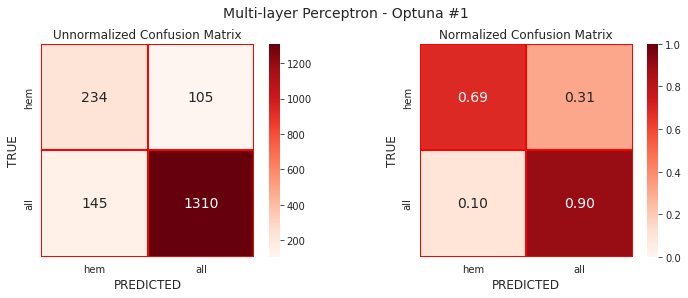

In [ ]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Multi-layer Perceptron - Optuna #1', y_test, y_pred_mlp, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.62      0.69      0.65       339
         all       0.93      0.90      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.80      0.78      1794
weighted avg       0.87      0.86      0.86      1794



## Output for hidden_layer_sizes=(10, 10, 10)

#### Start with 2 trials

In [41]:
study.optimize(objective, n_jobs=-1, n_trials=2)

[I 2023-04-27 15:55:08,771] Trial 1 finished with value: 0.7414158129121748 and parameters: {'momentum': 0.9385623378731146, 'learning_rate_init': 0.0006729190055126267, 'power_t': 0.30000000000000004}. Best is trial 1 with value: 0.7414158129121748.
[I 2023-04-27 15:56:48,770] Trial 0 finished with value: 0.744299994627349 and parameters: {'momentum': 0.8402646150256428, 'learning_rate_init': 0.00020514633692073205, 'power_t': 0.5}. Best is trial 0 with value: 0.744299994627349.


#### Continue with 18 more trials

In [52]:
study.optimize(objective, n_jobs=-1, n_trials=18)

[I 2023-04-27 16:22:00,455] Trial 2 finished with value: 0.739378491527886 and parameters: {'momentum': 0.5496368327060469, 'learning_rate_init': 3.4527600211595096e-05, 'power_t': 0.7}. Best is trial 0 with value: 0.744299994627349.
[I 2023-04-27 16:22:12,366] Trial 4 finished with value: 0.7262624080348398 and parameters: {'momentum': 0.9401278226959899, 'learning_rate_init': 1.0895431635911366e-05, 'power_t': 0.2}. Best is trial 0 with value: 0.744299994627349.
[I 2023-04-27 16:22:14,550] Trial 5 finished with value: 0.7540065223936931 and parameters: {'momentum': 0.8954450693553963, 'learning_rate_init': 0.00012240023497559534, 'power_t': 0.8}. Best is trial 5 with value: 0.7540065223936931.
[I 2023-04-27 16:22:37,757] Trial 3 finished with value: 0.7476209131704538 and parameters: {'momentum': 0.8115558854062294, 'learning_rate_init': 0.0003996363555378716, 'power_t': 0.2}. Best is trial 5 with value: 0.7540065223936931.
[I 2023-04-27 16:28:29,748] Trial 6 finished with value: 0.7

#### Finish with 30 trials (total 50 trials)

In [53]:
study.optimize(objective, n_jobs=-1, n_trials=30)

[I 2023-04-27 17:02:32,678] Trial 20 finished with value: 0.7535196538300831 and parameters: {'momentum': 0.6971119336865255, 'learning_rate_init': 0.00014185289578121037, 'power_t': 0.5}. Best is trial 11 with value: 0.7614242867803882.
[I 2023-04-27 17:02:33,450] Trial 22 finished with value: 0.7541229980490903 and parameters: {'momentum': 0.7109747186824044, 'learning_rate_init': 0.00013423591757077643, 'power_t': 0.5}. Best is trial 11 with value: 0.7614242867803882.
[I 2023-04-27 17:02:40,536] Trial 21 finished with value: 0.7516036660319434 and parameters: {'momentum': 0.7251792333997664, 'learning_rate_init': 0.00013899989147938947, 'power_t': 0.5}. Best is trial 11 with value: 0.7614242867803882.
[I 2023-04-27 17:02:59,376] Trial 23 finished with value: 0.7360772839465812 and parameters: {'momentum': 0.49867096149568746, 'learning_rate_init': 0.00043032579408755814, 'power_t': 0.5}. Best is trial 11 with value: 0.7614242867803882.
[I 2023-04-27 17:09:15,403] Trial 24 finished w

## Best Parameters

In [54]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 50
Best trial:
  Value: 0.7614242867803882
  Params: 
    momentum: 0.5154600774171402
    learning_rate_init: 0.0006484157868557874
    power_t: 0.4


## Re-fit the model

In [55]:
params_mlp = trial.params
params_mlp

{'momentum': 0.5154600774171402,
 'learning_rate_init': 0.0006484157868557874,
 'power_t': 0.4}

In [56]:
### mlp = MLPClassifier(**params_mlp, hidden_layer_sizes=(10, 10, 10), random_state=random_state)
mlp = MLPClassifier(**params_mlp, hidden_layer_sizes=(100, 50), random_state=random_state)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10),
              learning_rate_init=0.0006484157868557874,
              momentum=0.5154600774171402, power_t=0.4, random_state=10)

In [57]:
# Save the model
joblib.dump(mlp, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/mlp_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/mlp_f1ma_1.pkl']

In [58]:
y_pred_mlp = mlp.predict(X_test)

In [59]:
accuracy = accuracy_score(y_test, y_pred_mlp)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.78


In [60]:
# Compare training and testing scores
print(f"Training Data Score: {mlp.score(X_train, y_train)}")
print(f"Testing Data Score: {mlp.score(X_test, y_test)}")

Training Data Score: 0.9670219014852731
Testing Data Score: 0.8377926421404682


In [61]:
cm = confusion_matrix(y_test, y_pred_mlp)
print(cm)

[[ 244   95]
 [ 196 1259]]


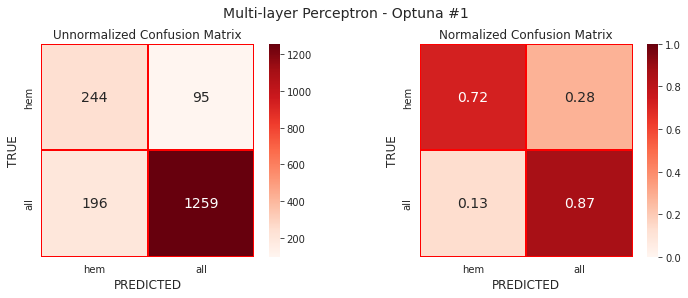

In [62]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Multi-layer Perceptron - Optuna #1', y_test, y_pred_mlp, target_names, 'Reds')

In [63]:
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.55      0.72      0.63       339
         all       0.93      0.87      0.90      1455

    accuracy                           0.84      1794
   macro avg       0.74      0.79      0.76      1794
weighted avg       0.86      0.84      0.85      1794



## =================================================

# Gaussian NB - Optuna

## Optuna Objective Function

In [38]:
def objective(trial):
    """Define the objective function"""

    params = {
        'var_smoothing' : trial.suggest_float('var_smoothing',1e-9, 1e-1, log=True)
    }

    # Fit the model
    model = GaussianNB(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [39]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 15:12:41,211] A new study created in memory with name: no-name-7a1f5b10-9f96-4ce5-ab87-ce80c7889386


## Optimize the Objective Function

In [66]:
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2023-04-27 17:52:14,409] Trial 0 finished with value: 0.4906980415617651 and parameters: {'var_smoothing': 0.0031478354776236675}. Best is trial 0 with value: 0.4906980415617651.
[I 2023-04-27 17:52:14,475] Trial 3 finished with value: 0.49430763106074976 and parameters: {'var_smoothing': 3.553181647724306e-05}. Best is trial 3 with value: 0.49430763106074976.
[I 2023-04-27 17:52:14,519] Trial 1 finished with value: 0.503894216253911 and parameters: {'var_smoothing': 2.841539056916215e-06}. Best is trial 1 with value: 0.503894216253911.
[I 2023-04-27 17:52:14,553] Trial 2 finished with value: 0.503894216253911 and parameters: {'var_smoothing': 1.9969077716416764e-06}. Best is trial 1 with value: 0.503894216253911.
[I 2023-04-27 17:52:15,494] Trial 6 finished with value: 0.48858875138346647 and parameters: {'var_smoothing': 0.0010372928592880437}. Best is trial 1 with value: 0.503894216253911.
[I 2023-04-27 17:52:15,611] Trial 7 finished with value: 0.5035656774787209 and parameters:

## Best Parameters

In [67]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.5066241007663601
  Params: 
    var_smoothing: 5.08735387967818e-06


## Re-fit the model

In [68]:
params_gnb = trial.params
params_gnb

{'var_smoothing': 5.08735387967818e-06}

In [69]:
gnb = GaussianNB(**params_gnb)
gnb.fit(X_train, y_train)

GaussianNB(var_smoothing=5.08735387967818e-06)

In [70]:
# Save the model
joblib.dump(gnb, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/gnb_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/gnb_f1ma_1.pkl']

In [71]:
y_pred_gnb = gnb.predict(X_test)

In [72]:
accuracy = accuracy_score(y_test, y_pred_gnb)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 77.09


In [73]:
# Compare training and testing scores
print(f"Training Data Score: {gnb.score(X_train, y_train)}")
print(f"Testing Data Score: {gnb.score(X_test, y_test)}")

Training Data Score: 0.7226651002769153
Testing Data Score: 0.7709030100334449


In [74]:
cm = confusion_matrix(y_test, y_pred_gnb)
print(cm)

[[  35  304]
 [ 107 1348]]


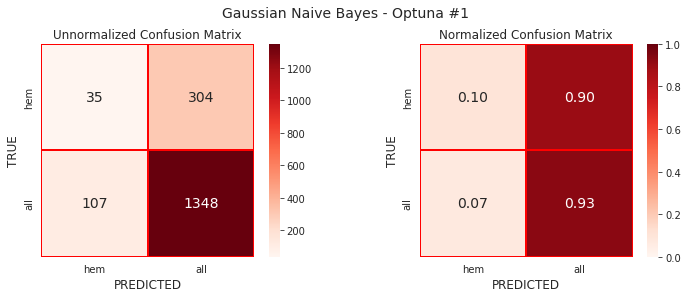

In [75]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Gaussian Naive Bayes - Optuna #1', y_test, y_pred_gnb, target_names, 'Reds')

In [76]:
print(classification_report(y_test, y_pred_gnb, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.25      0.10      0.15       339
         all       0.82      0.93      0.87      1455

    accuracy                           0.77      1794
   macro avg       0.53      0.51      0.51      1794
weighted avg       0.71      0.77      0.73      1794



## =================================================

# Extra Trees - Optuna

## Optuna Objective Function

In [132]:
def objective(trial):
    """Define the objective function"""

    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 10, 700, 10),
        # 'max_depth' : trial.suggest_int('max_depth', 1, 32),
        # 'max_features' : trial.suggest_int('max_features', 2, 20),
        'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        # 'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy'])
    }

    # Fit the model
    model = ExtraTreesClassifier(**params, random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [133]:
study = optuna.create_study(direction='maximize')

[I 2023-04-27 21:00:07,190] A new study created in memory with name: no-name-2d245a97-d8ce-4c8b-b10c-9503ecd52178


## Optimize the Objective Function

In [134]:
study.optimize(objective, n_jobs=-1, n_trials=100)

[I 2023-04-27 21:00:21,836] Trial 3 finished with value: 0.7221493723322312 and parameters: {'n_estimators': 100, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 3 with value: 0.7221493723322312.
[I 2023-04-27 21:00:23,360] Trial 4 finished with value: 0.7126728475144765 and parameters: {'n_estimators': 20, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 3 with value: 0.7221493723322312.
[I 2023-04-27 21:00:27,197] Trial 0 finished with value: 0.6788429278092252 and parameters: {'n_estimators': 210, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.7221493723322312.
[I 2023-04-27 21:00:49,645] Trial 2 finished with value: 0.7270338017943913 and parameters: {'n_estimators': 490, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 2 with v

## Best Parameters

In [135]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7659337325026296
  Params: 
    n_estimators: 290
    max_features: sqrt
    min_samples_split: 5
    min_samples_leaf: 3
    criterion: entropy


## Re-fit the model

In [136]:
params_etree = trial.params
params_etree

{'n_estimators': 290,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'criterion': 'entropy'}

In [137]:
etree = ExtraTreesClassifier(**params_etree, random_state=random_state)
etree.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', min_samples_leaf=3,
                     min_samples_split=5, n_estimators=290, random_state=10)

In [138]:
# Save the model
joblib.dump(etree, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/etree_f1ma_1.pkl')

['/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/etree_f1ma_1.pkl']

In [139]:
y_pred_etree = etree.predict(X_test)

In [140]:
accuracy = accuracy_score(y_test, y_pred_etree)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.62


In [141]:
# Compare training and testing scores
print(f"Training Data Score: {etree.score(X_train, y_train)}")
print(f"Testing Data Score: {etree.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8561872909698997


In [142]:
cm = confusion_matrix(y_test, y_pred_etree)
print(cm)

[[ 211  128]
 [ 130 1325]]


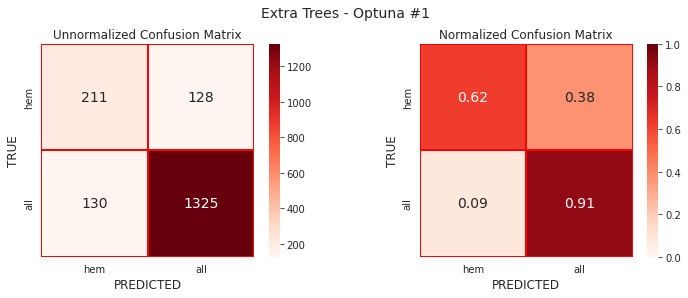

In [143]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Extra Trees - Optuna #1', y_test, y_pred_etree, target_names, 'Reds')

In [144]:
print(classification_report(y_test, y_pred_etree, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.62      0.62      0.62       339
         all       0.91      0.91      0.91      1455

    accuracy                           0.86      1794
   macro avg       0.77      0.77      0.77      1794
weighted avg       0.86      0.86      0.86      1794



# STACKING CLASSIFICATION

## XGBoost static paramters - Final Estimator

In [11]:
# XGBoost static parameters
static_params = { 
        'objective' : 'binary:logistic', 
        'eval_metric' : 'auc', 
        'random_state' : random_state
}

static_params_gpu = {
        'tree_method' : 'gpu_hist', 
        'gpu_id' : 0
}

## Parameters for tuned base models

In [76]:
params_knn = {
    'n_neighbors': 6,
    'metric': 'euclidean',
    'weights': 'distance'
    }

params_svm = {
  	'C' : 0.12103996361181649,
    'gamma': 24.34232406568725
    }

params_lr = {
    'penalty': 'l2',
    'C': 0.41725619274351355,
    'tol': 0.0034947786528423015,
    'fit_intercept': True,
    'solver': 'liblinear'
    }

params_rf = {
    'n_estimators': 630,
    'max_features': 'sqrt',
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'criterion': 'entropy'
    }

params_gnb = {
    'var_smoothing': 5.08735387967818e-06
    }

#  hidden_layer_sizes=(10, 10, 10) 
# params_mlp = {
#     'momentum': 0.5154600774171402,
#     'learning_rate_init': 0.0006484157868557874,
#     'power_t': 0.4
#     }

#  hidden_layer_sizes=(100, 50) 
params_mlp = {
    'momentum': 0.7467805285225793, 
    'learning_rate_init': 0.0004616656166415659, 
    'power_t': 0.2
    }

params_etree = {
    'n_estimators': 290,
    'max_features': 'sqrt',
    'min_samples_split': 5,
    'min_samples_leaf': 3,
    'criterion': 'entropy'
    }
             

## All Estimators

In [77]:
# Initializing Support Vector Classifier
svm = SVC(**params_svm, 
          kernel='linear', 
          random_state=random_state)

# Initializing KNN Classifier
knn = KNeighborsClassifier(**params_knn)

# Initialing Logistic Regression
lr = LogisticRegression(**params_lr, 
                        random_state=random_state)

# Initializing Random Forest Classifier
rf = RandomForestClassifier(**params_rf, 
                            random_state=random_state)

# Initializing Naive Bayes 
gnb = GaussianNB(**params_gnb)

# Initialize Multi-layer Perceptron Classifier
mlp = MLPClassifier(**params_mlp, 
                    ### hidden_layer_sizes=(10, 10, 10), 
                    hidden_layer_sizes=(100, 50),
                    random_state=random_state)

# Initialize Extra-trees Classifier
etree = ExtraTreesClassifier(**params_etree,
                             random_state=random_state)

##  xgb = XGBClassifier(**static_params, **static_params_gpu, **params_xgb)

#### List of all estimators tuples

In [78]:
estimators_all = [
    ('svm', svm),
    ('knn', knn),
    ('lr', lr),
    ('rf', rf),
    ('gnb', gnb),
    ('mlp', mlp),
    ('etree', etree)

]

## Function to fit models

In [15]:
def fit_clf(models_d):

    fit_models = {}

    # Loop through model pipelines, tuning each one and saving it to fitted_models
    for name, model in models_d.items():
        # Fit model on X_train, y_train
        model.fit(X_train, y_train)

        # Store model in fitted_models[name]
        fit_models[name] = model

        # Print '{name} has been fitted'
        print(name, 'has been fitted')
    return fit_models

## Function to evaluate models

In [49]:
def evaluation(models):
    lst = []
    for name, model in models.items():
        pred = model.predict(X_test)
        lst.append([name, f1_score(y_test, pred, average='macro'),
                    accuracy_score(y_test, pred),
                    roc_auc_score(y_test, pred)])

    eval_df = pd.DataFrame(lst, columns=['model', 'f1_macro', 'accuracy', 'AUC'])
    eval_df.set_index('model', inplace = True)
    return eval_df

## Fit and evaluate all tuned models

In [36]:
fitted_models = fit_clf(dict(estimators_all))

svm has been fitted
knn has been fitted
lr has been fitted
rf has been fitted
gnb has been fitted
mlp has been fitted
etree has been fitted


In [37]:
evaluation(fitted_models)

,f1_macro,accuracy,AUC
model,,,
svm,0.761333,0.846711,0.774269
knn,0.691723,0.779264,0.730426
lr,0.750517,0.835006,0.771578
rf,0.768270,0.857302,0.769486
gnb,0.506624,0.770903,0.514853
mlp,0.771574,0.851171,0.789463
etree,0.765934,0.856187,0.766536


## Fit and evaluate Stacking Classifier

#### List of base estimators tuples (drop knn and gnb)

In [81]:
estimators_l = [
    ('svm', svm),
    # ('knn', knn),
    ('lr', lr),
    ('rf', rf),
    #('gnb', gnb),
    ('mlp', mlp),
    ('etree', etree)
]

#### Build stack model

In [85]:
# Build stack model, not tuned
stack_clf_nt = StackingClassifier(
    estimators=estimators_l, 
    final_estimator=XGBClassifier(**static_params, **static_params_gpu), 
    n_jobs=-1
)

In [86]:
sc_nt = {'stack' : stack_clf_nt}
fitted_stack = fit_clf(sc_nt)

stack has been fitted


In [87]:
evaluation(fitted_stack)

,f1_macro,accuracy,AUC
model,,,
stack,0.793864,0.872352,0.796865


### Performance for not tuned stacking classifier

In [88]:
# Save the model
# joblib.dump(stack_clf, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/stack_xgb_not_tuned.save')
joblib.dump(stack_clf_nt, './saved_models/batch_4_stack/stack_xgb_not_tuned.pkl')

['./saved_models/batch_4_stack/stack_xgb_not_tuned.pkl']

In [89]:
y_pred_st_nt = stack_clf_nt.predict(X_test)

In [90]:
accuracy = accuracy_score(y_test, y_pred_st_nt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.24


In [91]:
# Compare training and testing scores
print(f"Training Data Score: {stack_clf_nt.score(X_train, y_train)}")
print(f"Testing Data Score: {stack_clf_nt.score(X_test, y_test)}")

Training Data Score: 0.9994126038432491
Testing Data Score: 0.8723522853957637


In [92]:
cm = confusion_matrix(y_test, y_pred_st_nt)
print(cm)

[[ 229  110]
 [ 119 1336]]


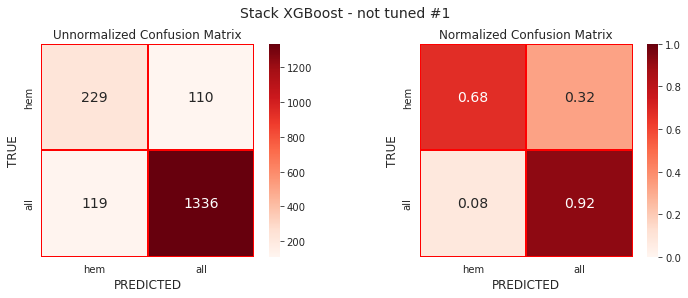

In [94]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Stack XGBoost - not tuned #1', y_test, y_pred_st_nt, target_names, 'Reds')

In [95]:
print(classification_report(y_test, y_pred_st_nt, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.66      0.68      0.67       339
         all       0.92      0.92      0.92      1455

    accuracy                           0.87      1794
   macro avg       0.79      0.80      0.79      1794
weighted avg       0.87      0.87      0.87      1794



# Tuning Stacking Classifier - #1

In [96]:
# Build stack model
stack_clf = StackingClassifier(
    estimators=estimators_l, 
    final_estimator=XGBClassifier(**static_params, **static_params_gpu), 
    n_jobs=-1
)

## Optuna Objective Function

In [19]:
def objective(trial):
    """Define the objective function"""

    params = {
        'final_estimator__max_depth': trial.suggest_int('final_estimator__max_depth', 1, 10),
        'final_estimator__learning_rate': trial.suggest_loguniform('final_estimator__learning_rate', 0.01, 1.0),
        'final_estimator__n_estimators': trial.suggest_int('final_estimator__n_estimators', 50, 600),
        'final_estimator__min_child_weight': trial.suggest_int('final_estimator__min_child_weight', 1, 12),
        'final_estimator__gamma': trial.suggest_loguniform('final_estimator__gamma', 1e-8, 1.0),
        'final_estimator__subsample': trial.suggest_loguniform('final_estimator__subsample', 0.01, 1.0),
        'final_estimator__colsample_bytree': trial.suggest_loguniform('final_estimator__colsample_bytree', 0.01, 1.0),
        'final_estimator__reg_alpha': trial.suggest_loguniform('final_estimator__reg_alpha', 1e-8, 1.0),
        'final_estimator__reg_lambda': trial.suggest_loguniform('final_estimator__reg_lambda', 1e-8, 1.0)
    }


    # Fit the model
    stack_clf.set_params(**params)
    stack_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = stack_clf.predict(X_test)

    # Evaluate predictions
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

## Optuna Study

In [20]:
study = optuna.create_study(direction='maximize')

[I 2023-04-28 23:13:16,006] A new study created in memory with name: no-name-e57c7ec6-3a6b-49f8-808f-27472d368835


## Optimize the Objective Function

#### First 10 trials

In [21]:
study.optimize(objective, n_trials=10)

[I 2023-04-28 23:32:35,442] Trial 0 finished with value: 0.789325719527346 and parameters: {'final_estimator__max_depth': 2, 'final_estimator__learning_rate': 0.20619638831226886, 'final_estimator__n_estimators': 142, 'final_estimator__min_child_weight': 7, 'final_estimator__gamma': 0.008399758742498467, 'final_estimator__subsample': 0.044427467266057424, 'final_estimator__colsample_bytree': 0.6053112374704286, 'final_estimator__reg_alpha': 6.476863942999051e-05, 'final_estimator__reg_lambda': 0.0016306245956206069}. Best is trial 0 with value: 0.789325719527346.
[I 2023-04-28 23:53:18,914] Trial 1 finished with value: 0.7906647936243822 and parameters: {'final_estimator__max_depth': 6, 'final_estimator__learning_rate': 0.08751726849513616, 'final_estimator__n_estimators': 66, 'final_estimator__min_child_weight': 10, 'final_estimator__gamma': 3.413454878548282e-05, 'final_estimator__subsample': 0.4619089765621419, 'final_estimator__colsample_bytree': 0.18976171152875343, 'final_estimat

#### Next 10 trials

In [24]:
study.optimize(objective, n_trials=10)

[I 2023-04-29 02:46:00,508] Trial 10 finished with value: 0.7907828915736601 and parameters: {'final_estimator__max_depth': 8, 'final_estimator__learning_rate': 0.011827277221752064, 'final_estimator__n_estimators': 64, 'final_estimator__min_child_weight': 4, 'final_estimator__gamma': 0.13375412180841692, 'final_estimator__subsample': 0.011535237647720993, 'final_estimator__colsample_bytree': 0.011357956088591064, 'final_estimator__reg_alpha': 3.0986297737597616e-08, 'final_estimator__reg_lambda': 0.0011123513976140083}. Best is trial 9 with value: 0.7945359890534929.
[I 2023-04-29 03:04:47,888] Trial 11 finished with value: 0.7920090562476616 and parameters: {'final_estimator__max_depth': 8, 'final_estimator__learning_rate': 0.010879362307428532, 'final_estimator__n_estimators': 50, 'final_estimator__min_child_weight': 4, 'final_estimator__gamma': 0.32582367954300784, 'final_estimator__subsample': 0.010067699096406897, 'final_estimator__colsample_bytree': 0.010609204977901467, 'final_

## Best Parameters

In [27]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 20
Best trial:
  Value: 0.8015603057404062
  Params: 
    final_estimator__max_depth: 9
    final_estimator__learning_rate: 0.04944862780799588
    final_estimator__n_estimators: 208
    final_estimator__min_child_weight: 8
    final_estimator__gamma: 0.8968413073938504
    final_estimator__subsample: 0.07001631038729961
    final_estimator__colsample_bytree: 0.9638519070162351
    final_estimator__reg_alpha: 0.29333886546035415
    final_estimator__reg_lambda: 0.00011294508522760805


## Re-fit the model

In [97]:
params = trial.params
params

{'final_estimator__max_depth': 9,
 'final_estimator__learning_rate': 0.04944862780799588,
 'final_estimator__n_estimators': 208,
 'final_estimator__min_child_weight': 8,
 'final_estimator__gamma': 0.8968413073938504,
 'final_estimator__subsample': 0.07001631038729961,
 'final_estimator__colsample_bytree': 0.9638519070162351,
 'final_estimator__reg_alpha': 0.29333886546035415,
 'final_estimator__reg_lambda': 0.00011294508522760805}

In [98]:
stack_clf_t = stack_clf.set_params(**params)
stack_clf_t.fit(X_train, y_train)

StackingClassifier(estimators=[('svm',
                                SVC(C=0.12103996361181649,
                                    gamma=24.34232406568725, kernel='linear',
                                    random_state=10)),
                               ('lr',
                                LogisticRegression(C=0.41725619274351355,
                                                   random_state=10,
                                                   solver='liblinear',
                                                   tol=0.0034947786528423015)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       min_samples_split=5,
                                                       n_estimators=630,
                                                       random_state=10)),
                               ('mlp',
                                MLPClas...
                                                 gpu_id=0, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.04944862780799588,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=9, max_leaves=None,
                                                 min_child_weight=8,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=208, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=10, ...),
                   n_jobs=-1)

In [99]:
# Save the model
# joblib.dump(stack_clf, '/content/drive/MyDrive/Omdena/Team1/saved_models/batch_4_stack/stack_xgb_tuned.save')
joblib.dump(stack_clf_t, './saved_models/batch_4_stack/stack_xgb_tuned.pkl')

['./saved_models/batch_4_stack/stack_xgb_tuned.pkl']

In [100]:
y_pred_st_t = stack_clf_t.predict(X_test)

In [101]:
accuracy = accuracy_score(y_test, y_pred_st_t)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 87.90


In [102]:
# Compare training and testing scores
print(f"Training Data Score: {stack_clf_t.score(X_train, y_train)}")
print(f"Testing Data Score: {stack_clf_t.score(X_test, y_test)}")

Training Data Score: 0.9997482587899639
Testing Data Score: 0.879041248606466


In [103]:
cm = confusion_matrix(y_test, y_pred_st_t)
print(cm)

[[ 228  111]
 [ 106 1349]]


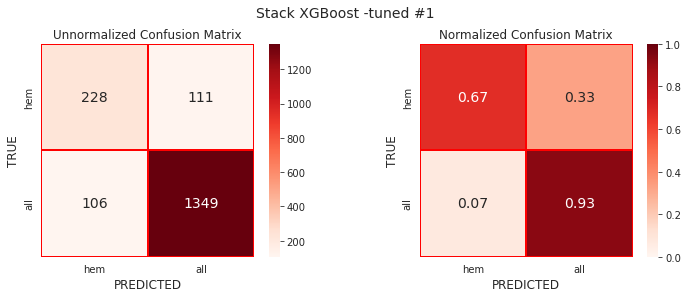

In [104]:
# Plot confusion matrix and its normalized version.
mu.plot_cm_unnorm_and_norm('Stack XGBoost -tuned #1', y_test, y_pred_st_t, target_names, 'Reds')

In [105]:
print(classification_report(y_test, y_pred_st_t, target_names=target_names))

              precision    recall  f1-score   support

         hem       0.68      0.67      0.68       339
         all       0.92      0.93      0.93      1455

    accuracy                           0.88      1794
   macro avg       0.80      0.80      0.80      1794
weighted avg       0.88      0.88      0.88      1794



In [106]:
evaluation({'stack' : stack_clf_t})

,f1_macro,accuracy,AUC
model,,,
stack,0.80156,0.879041,0.799857
